In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from postgres.config import SessionLocal
from postgres.models import BoxScores, ClusteredPlayers, TestPlayerPredictions, AdvancedPlayerStats

In [3]:
session = SessionLocal()

games = session.query(BoxScores).all()
data = []
for game in games:
    game_dict = {column.name: getattr(game, column.name) for column in game.__table__.columns}
    data.append(game_dict)
df = pd.DataFrame(data)
df = df[df['MIN'] != 0]
df
df = df.dropna(subset=['WL'])
df.describe()


,id,MIN,PTS,FGM,FGA,FG_PERCENT,THREE_PM,THREE_PA,THREE_PERCENT,FTM,...,STL,BLK,TOV,PF,PLUS_MINUS,FP,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,21967.000000,21967.000000,21967.000000,21967.000000,21967.000000,20835.000000,21967.000000,21967.000000,17516.000000,21967.000000,...,21967.000000,21967.000000,21967.000000,21967.000000,21967.000000,21967.000000,21360.000000,21360.000000,21360.000000,21360.000000
mean,11275.916875,22.652023,10.662448,3.899759,8.372013,45.508059,1.262667,3.518733,33.387577,1.600264,...,0.772705,0.467519,1.275413,1.760049,-0.034825,21.813771,21.789757,21.715073,21.649860,21.170046
std,6590.395613,10.796905,8.825326,3.247291,6.047800,23.794564,1.525533,3.160247,28.387770,2.273991,...,0.991315,0.828523,1.423003,1.438189,11.624086,14.942827,13.053008,12.613279,12.415922,11.928892
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-56.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,5509.500000,15.000000,4.000000,1.000000,4.000000,33.300000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-7.000000,10.000000,11.900000,12.200000,12.285714,12.179444
50%,11016.000000,24.000000,9.000000,3.000000,7.000000,46.200000,1.000000,3.000000,33.300000,1.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,20.000000,20.200000,20.200000,20.071429,19.469545
75%,17051.500000,31.000000,16.000000,6.000000,12.000000,58.800000,2.000000,5.000000,50.000000,2.000000,...,1.000000,1.000000,2.000000,3.000000,7.000000,31.350000,30.166667,29.860000,29.657143,28.537946
max,22576.000000,50.000000,60.000000,22.000000,39.000000,100.000000,12.000000,20.000000,100.000000,21.000000,...,8.000000,10.000000,11.000000,6.000000,48.000000,98.300000,81.600000,80.120000,75.671429,72.200000


In [4]:
players = session.query(AdvancedPlayerStats).all()
clustered_players = session.query(ClusteredPlayers).all()

cluster_dict = {player.PLAYER: player.CLUSTER for player in clustered_players}
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {}
    player_dict['PLAYER'] = player.PLAYER
    # Assign the cluster if the player exists in clustered_players, else NAN
    player_dict['CLUSTER'] = cluster_dict.get(player.PLAYER, np.nan)
    data.append(player_dict)

dataset_clusters = pd.DataFrame(data)

In [5]:
dataset_clusters.head(10)

,PLAYER,CLUSTER
0,alperen sengun,9
1,scotty pippen jr.,3
2,deni avdija,2
3,donte divincenzo,11
4,jaden mcdaniels,4
5,nicolas batum,5
6,jalen smith,1
7,amir coffey,8
8,jalen wilson,8
9,julius randle,2


In [6]:
clusterDict = {}
df.describe()

,id,MIN,PTS,FGM,FGA,FG_PERCENT,THREE_PM,THREE_PA,THREE_PERCENT,FTM,...,STL,BLK,TOV,PF,PLUS_MINUS,FP,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,21967.000000,21967.000000,21967.000000,21967.000000,21967.000000,20835.000000,21967.000000,21967.000000,17516.000000,21967.000000,...,21967.000000,21967.000000,21967.000000,21967.000000,21967.000000,21967.000000,21360.000000,21360.000000,21360.000000,21360.000000
mean,11275.916875,22.652023,10.662448,3.899759,8.372013,45.508059,1.262667,3.518733,33.387577,1.600264,...,0.772705,0.467519,1.275413,1.760049,-0.034825,21.813771,21.789757,21.715073,21.649860,21.170046
std,6590.395613,10.796905,8.825326,3.247291,6.047800,23.794564,1.525533,3.160247,28.387770,2.273991,...,0.991315,0.828523,1.423003,1.438189,11.624086,14.942827,13.053008,12.613279,12.415922,11.928892
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-56.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,5509.500000,15.000000,4.000000,1.000000,4.000000,33.300000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-7.000000,10.000000,11.900000,12.200000,12.285714,12.179444
50%,11016.000000,24.000000,9.000000,3.000000,7.000000,46.200000,1.000000,3.000000,33.300000,1.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,20.000000,20.200000,20.200000,20.071429,19.469545
75%,17051.500000,31.000000,16.000000,6.000000,12.000000,58.800000,2.000000,5.000000,50.000000,2.000000,...,1.000000,1.000000,2.000000,3.000000,7.000000,31.350000,30.166667,29.860000,29.657143,28.537946
max,22576.000000,50.000000,60.000000,22.000000,39.000000,100.000000,12.000000,20.000000,100.000000,21.000000,...,8.000000,10.000000,11.000000,6.000000,48.000000,98.300000,81.600000,80.120000,75.671429,72.200000


In [7]:
# Map the 'Cluster' column from clusterdf to the dataset based on 'Player'
clusterDict = dataset_clusters.set_index('PLAYER')['CLUSTER'].to_dict()

# Map the 'CLUSTER' column in the dataset
df['CLUSTER'] = df['PLAYER'].map(clusterDict)

In [8]:
# Remove players without a cluster
# df = df.dropna(subset=['CLUSTER'])
df.sort_values(by=['GAME_DATE'], ascending = [False], inplace=True)
print(df['CLUSTER'].value_counts(dropna=False))


CLUSTER
NaN    4384
6      2234
11     2085
12     1611
4      1549
3      1460
8      1359
13     1136
7      1047
2       968
5       910
1       834
0       715
9       681
10      502
14      492
Name: count, dtype: int64


In [9]:
df['MIN'] = df['MIN'] + np.random.uniform(-3, 3, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)
df['MIN']

0       13.190028
41      26.042133
29      36.329520
30      24.299344
31      20.038724
          ...    
6749    24.203345
7288    26.044364
3626    26.503436
3712    34.097401
3678    33.941481
Name: MIN, Length: 21967, dtype: float64

In [10]:
# Replace NaN with a placeholder before encoding
df['CLUSTER'] = df['CLUSTER'].fillna('CLUSTER_NAN')
featureNames = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN']
labelName = ['FP']
dfFeatures = df[featureNames]
dfLabels = df[labelName]
# Ensures Cluster is a categorical variable; one-hot encoded
dfFeatures = pd.get_dummies(dfFeatures, columns=['CLUSTER'], drop_first=False)

In [11]:
labels = np.array(dfLabels)
features = np.array(dfFeatures)

In [12]:
df = df[['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN']]
players = df['PLAYER']
gameDates = df['GAME_DATE']

In [13]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.25, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [14]:
import pickle
rf = RandomForestRegressor(
    random_state=4,
)
rf.fit(train, trainLabels)

with open("../models/RFCluster.sav", 'wb') as f:
    pickle.dump(rf, f)

C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [15]:
train_predictions = rf.predict(train)
predictions = rf.predict(test)


In [16]:
# Create a mapping from one-hot encoded columns back to cluster numbers
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
reverse_cluster_map = {i: col.split('_')[-1] for i, col in enumerate(cluster_columns, start=1)}

In [17]:
feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)
df['CLUSTER'] = df[cluster_columns].idxmax(axis=1)  # Get the column with the highest value (1 in this case)
# Map back to original cluster numbers safely
def safe_cluster_map(value):
    if isinstance(value, str) and value.startswith('CLUSTER_'):
        try:
            return float(value.split('_')[-1])
        except ValueError:
            return np.nan
    return np.nan

df['CLUSTER'] = df['CLUSTER'].map(safe_cluster_map)

# Drop the one-hot encoded columns if no longer needed
df = df.drop(columns=cluster_columns)
df['PLAYER'] = testPlayers
df['GAME DATE'] = testDates
df['ACTUAL'] = testLabels
df['PREDICTED'] = predictions
df['ERROR'] = abs(df['ACTUAL'] - df['PREDICTED'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [18]:
df.describe()

,CLUSTER,ACTUAL,PREDICTED,ERROR
count,4417.000000,5492.000000,5492.000000,5492.000000
mean,7.111388,21.562637,21.830221,6.077057
std,4.022671,14.721766,12.849103,5.245252
min,0.000000,-2.800000,-0.234000,0.002000
25%,4.000000,10.200000,12.108250,2.081875
50%,7.000000,19.900000,20.994500,4.749000
75%,11.000000,30.900000,30.714250,8.682000
max,14.000000,94.200000,74.520000,41.429000


In [19]:
df.head(5)

,PLAYER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,MIN,CLUSTER,GAME DATE,ACTUAL,PREDICTED,ERROR
0,anthony black,22.033333,21.58,21.85,21.85,23.443727,3.0,2024-11-03,3.8,19.544,15.744
1,michael porter jr.,33.0,31.58,31.58,31.58,31.071378,4.0,2024-11-02,29.0,31.966,2.966
2,shaedon sharpe,36.4,35.74,32.285714,27.381481,42.233963,12.0,2025-03-05,38.2,37.694,0.506
3,gg jackson,14.633333,11.06,10.171429,14.14,9.639628,0.0,2025-03-09,0.2,6.118,5.918
4,quentin grimes,18.733333,15.66,14.242857,11.015385,23.803208,12.0,2024-11-19,29.1,16.915,12.185


In [20]:
def safe_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

# Iterate over the DataFrame rows
for _, row in df.iterrows():
    existing_record = (
        session.query(TestPlayerPredictions)
        .filter_by(PLAYER=row['PLAYER'], GAME_DATE=row['GAME DATE'])
        .one_or_none()
    )
    if existing_record:
        # Update the existing record with new data
        existing_record.Last3_FP_Avg = safe_float(row['Last3_FP_Avg'])
        existing_record.Last5_FP_Avg = safe_float(row['Last5_FP_Avg'])
        existing_record.Last7_FP_Avg = safe_float(row['Last7_FP_Avg'])
        existing_record.Season_FP_Avg = safe_float(row['Season_FP_Avg'])
        existing_record.CLUSTER = row['CLUSTER']
        existing_record.ACTUAL = safe_float(row['ACTUAL'])
        existing_record.PREDICTED = safe_float(row['PREDICTED'])
        existing_record.ERROR = safe_float(row['ERROR'])
    else:
        # Create a new TestPlayerPredictions object if no existing record is found
        new_record = TestPlayerPredictions(
            PLAYER=row['PLAYER'],
            Last3_FP_Avg=safe_float(row['Last3_FP_Avg']),
            Last5_FP_Avg=safe_float(row['Last5_FP_Avg']),
            Last7_FP_Avg=safe_float(row['Last7_FP_Avg']),
            Season_FP_Avg=safe_float(row['Season_FP_Avg']),
            CLUSTER=row['CLUSTER'],
            GAME_DATE=row['GAME DATE'],
            ACTUAL=safe_float(row['ACTUAL']),
            PREDICTED=safe_float(row['PREDICTED']),
            ERROR=safe_float(row['ERROR']),
        )
        session.add(new_record)
session.commit()
session.close()


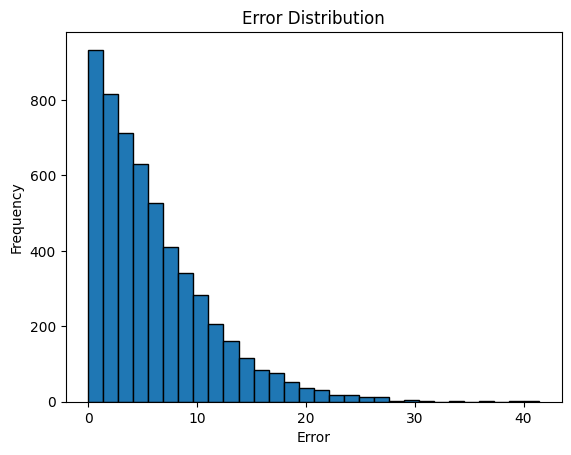

In [21]:
import matplotlib.pyplot as plt

plt.hist(df['ERROR'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

In [22]:
# Identfy unique list of cluster to loop over
dataset_clusters.head()

,PLAYER,CLUSTER
0,alperen sengun,9
1,scotty pippen jr.,3
2,deni avdija,2
3,donte divincenzo,11
4,jaden mcdaniels,4


In [23]:
clusterList = dataset_clusters['CLUSTER'].tolist()

In [24]:
uniqueClusterList = list(set(clusterList))
uniqueClusterList

['8',
 '10',
 '6',
 '13',
 '1',
 '14',
 nan,
 '7',
 '5',
 '0',
 '4',
 '2',
 '12',
 '11',
 '9',
 '3']

In [25]:
# ClusterError = 0
# for cluster in uniqueClusterList:
#     clusterdf = dataset[dataset['CLUSTER'] == cluster]
#     dfFeatures = clusterdf[['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg']]
#     dfLabels = clusterdf[['FP']]

#     labels = np.array(dfLabels).ravel()
#     features = np.array(dfFeatures)

#     train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=4)

#     reg = RandomForestRegressor(random_state=4)
#     reg.fit(train, train_labels)

#     train_predictions = reg.predict(train)
#     predictions = reg.predict(test)

#     df0 = pd.DataFrame(test, columns = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg'])
#     df0['Actual'] = test_labels
#     df0['Predicted'] = predictions
#     df0['Error'] = abs(df0['Actual'] - df0['Predicted'])
#     ClusterError += df0['Error'].mean()

#     print(f"Cluster {cluster} average error is roughly {df0['Error'].mean()}")
# avgClusterError = ClusterError/len(uniqueClusterList)
# print(f"Average error across clusters is: {avgClusterError}")